In [ ]:
import os
RUN_PLATFORM = os.getenv("RUN_PLATFORM") or "LOCAL"
if RUN_PLATFORM == "LOCAL":
	# Make sure that when not in docker, packages are installed
	!pip install -r requirements.txt
	data_dir = "data"
elif RUN_PLATFORM == "KAGGLE":
	data_dir = ""
metadata_path = os.path.join(data_dir, "train_metadata_updated.csv")
audio_dir = os.path.join(data_dir, "train_audio")
spectrogram_dir = os.path.join(data_dir, "train_spectogram")
os.makedirs(spectrogram_dir, exist_ok=True)
spectrogram_metadata_path = os.path.join(data_dir, "train_spectrogram.csv")

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
	# avoid rare bugs when image won't plot
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger

# loads .env file into runtime env vars
import os.path
if not os.path.isfile(".env"):
	raise Exception(".env must be created by copying .env.template and filling out the values")
from dotenv import load_dotenv
load_dotenv()

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import random_split, DataLoader, Dataset
from torchvision import transforms
import torchmetrics

# make it not fail in terminal execution
from IPython.display import display
from IPython.display import Audio

from types import SimpleNamespace
	# make dict to class
import pathlib
import platform

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

# Audio process
import librosa
import librosa.display
import cv2
import PIL

# Threading
from concurrent.futures import ThreadPoolExecutor
import concurrent.futures

# Wandb
import wandb
wandb.login() 
PROJECT_NAME = "bme-classification-bird_sounds"

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: asztrikx (asztrikx-budapesti-m-szaki-s-gazdas-gtudom-nyi-egyetem). Use `wandb login --relogin` to force relogin
d:\File\Study\BME\Msc\Haladó adatelemzés laboratórium\nhf\.venv\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


## Hyperparameter configuration, set random states

In [9]:
# hyperparameters
random_state = 42 # random state
test_val_size = 0.2 # size of test and validation together to the whole dataset
test_size = 0.5 # size of test to test and validation together
num_workers = 2 # number of workers for data loading
batch_size = 128

eval_only = True
is_score_on = True
visualize_and_analyze = True

# Faster exec. on newer GPUs
torch.set_float32_matmul_precision('medium')

# Fix random early on
np.random.seed(random_state)
torch.manual_seed(random_state)
torch.cuda.manual_seed_all(random_state);

## Metadata csv

In [ ]:
metadata = pd.read_csv(metadata_path)
metadata = metadata[metadata["delete"] == False].reset_index(drop=True)

## Transform data (Cached)

In [ ]:
def process_sound_file(file_path, save_dir, segment_length=3, sr=22050, n_mels=128, n_fft=2048, hop_length=512):
	y, sr = librosa.load(file_path, sr=sr)

	segment_samples = sr * segment_length
	num_segments = int(np.ceil(len(y) / segment_samples))

	spectrograms = []
	for i in range(num_segments):
		start = i * segment_samples
		end = start + segment_samples
		segment = y[start:end]

		#TODO how should padding work
		if len(segment) < segment_samples:
			if num_segments == 1:
				segment = np.pad(segment, (0, segment_samples - len(segment)), mode='wrap')
			else:
				missing_length = segment_samples - len(segment)
				segment = np.concatenate((segment, y[:missing_length]))
		mel_spec = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
		mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

		mel_spec_resized = cv2.resize(mel_spec_db, (128, 128)) # TODO n_mels?

		image_filename = f"{os.path.basename(file_path).replace('.ogg', '')}_seg{i}.png"
		image_path = os.path.join(save_dir, image_filename)
		plt.imsave(image_path, mel_spec_resized, cmap='inferno')

		spectrograms.append(image_path)

	return spectrograms

if not os.path.isfile(spectrogram_metadata_path):
	data = []
	metadata = metadata.iloc[0:2] # TODO avoid ssd murder until figured out

	# Create subdirs outside of loop
	for species in metadata["primary_label"].unique():
		os.makedirs(os.path.join(spectrogram_dir, species), exist_ok=True)

	with tqdm(total=len(metadata)) as pbar:
		with ThreadPoolExecutor() as executor:
			def get_spectrogram(filename):
				audio_path = os.path.join(audio_dir, filename)
				species = filename.split('/')[0]

				out_path = os.path.join(spectrogram_dir, species)
				audio_spectrograms = process_sound_file(audio_path, out_path, sr=32000)

				return audio_spectrograms

			futures = {
				executor.submit(get_spectrogram, filename): filename
				for filename in metadata["filename"]
			}
			for future in concurrent.futures.as_completed(futures):
				filename = futures[future]
				audio_spectrograms = future.result()

				# Get other data from metadata: do not do this in Dataset for caching
				row = metadata[metadata["filename"] == filename]
				latitude = row["latitude"].values[0]
				longitude = row["longitude"].values[0]
				author = row["author"].values[0]

				label = species

				for audio_spectrogram in audio_spectrograms:
					audio_spectrogram = os.path.relpath(audio_spectrogram, spectrogram_dir)
					data.append((filename, audio_spectrogram, label, author, latitude, longitude))
				pbar.update(1)

	spectrogram_df = pd.DataFrame(data, columns=["audio_path", "spectrogram_path", "label", "author", "latitude", "longitude"])
	spectrogram_df.to_csv(spectrogram_metadata_path, index=False)
else:
	spectrogram_df = pd.read_csv(spectrogram_metadata_path)

  0%|          | 0/100 [00:00<?, ?it/s]

## Visualize 1 audio file's spectrograms

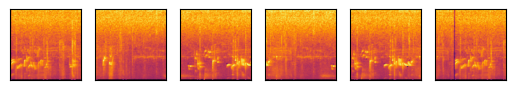

In [52]:
first_spectrograms = spectrogram_df[spectrogram_df["audio_path"] == spectrogram_df.iloc[0]["audio_path"]]
first_spectrograms_paths = first_spectrograms["spectrogram_path"].sort_values(ascending=True)

fig, ax = plt.subplots(1, len(first_spectrograms_paths))
for i, first_spectrograms_path in enumerate(first_spectrograms_paths):
	fullpath = os.path.join(spectrogram_dir, first_spectrograms_path)

	ax[i].imshow(mpimg.imread(fullpath))
	ax[i].set_xticks([])
	ax[i].set_yticks([])

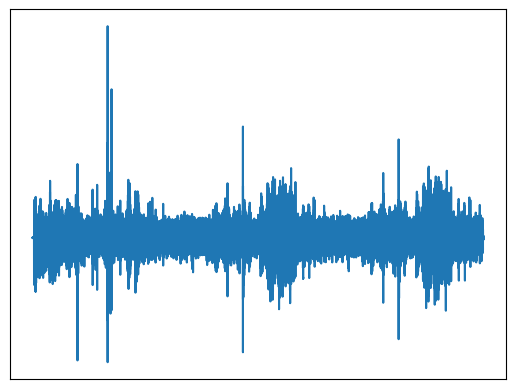

In [29]:
from pydub import AudioSegment

audio = AudioSegment.from_ogg(os.path.join(audio_dir, spectrogram_df.iloc[0]["audio_path"]))
samples = np.array(audio.get_array_of_samples())
if audio.channels == 2:
    samples = samples.reshape((-1, 2))
time_axis = np.linspace(0, len(audio) / 1000, num=len(samples))
plt.xticks([])
plt.yticks([])
plt.plot(time_axis, samples)

## Custom Dataset

In [ ]:
# Convert string labels to integer label IDs with LabelEncoder
label_encoder = LabelEncoder()
df = pd.read_csv(spectrogram_metadata_path)
df["label_id"] = label_encoder.fit_transform(df["label"])
df.to_csv(spectrogram_metadata_path)

In [ ]:
class BirdsDataset(Dataset):
	# override
	def __init__(self, csv, transform = None, target_transform = None):
		self.df = pd.read_csv(csv)
		self.transform = transform
		self.target_transform = target_transform

	# override
	def __len__(self):
		return len(self.df)

	# override
	def __getitem__(self, index):
		image_path = self.df.iloc[index]["spectrogram_path"]
		audio = PIL.Image.open(image_path).convert('RGB')
		audio = transforms.functional.to_tensor(audio)

		label = {
			"label": self.df.iloc[index]["label"],
			"label_id": self.df.iloc[index]["label_id"],
			"latitude": self.df.iloc[index]["latitude"],
			"longitude": self.df.iloc[index]["longitude"],
			"author": self.df.iloc[index]["author"],
		}
		
		if self.transform:
			audio = self.transform(audio).to(torch.float32)
		if self.target_transform:
			label = self.target_transform(label)
		return audio, label

## Data module

In [ ]:
class BirdsDataModule(pl.LightningDataModule):
	def __init__(self, spectrogram_metadata_path, batch_size, base_transform):
		super().__init__()
		self.batch_size = batch_size
		self.base_transform = transforms.Compose([
			base_transform
		])

		self.dataset_notransform = BirdsDataset(spectrogram_metadata_path, transform = None)
		self.dataset = BirdsDataset(spectrogram_metadata_path, transform = self.base_transform)
		self.setup()

	# override
	def setup(self, stage=None):
		train, test_val = train_test_split(self.dataset, test_size=test_val_size, random_state=random_state)
		test, val = train_test_split(test_val, test_size=test_size, random_state=random_state)
		self.train_dataset = train
		self.val_dataset = val
		self.test_dataset = test

	# override
	def train_dataloader(self):
		return torch.utils.data.DataLoader(
			self.train_dataset,
			batch_size=self.batch_size,
			num_workers=num_workers,
			pin_memory=True,
			drop_last=True,
			shuffle=False,
			persistent_workers=True
				# avoid recreating after every fast epoch
		)

	# override
	def val_dataloader(self):
		return torch.utils.data.DataLoader(
			self.val_dataset,
			batch_size=self.batch_size,
			num_workers=num_workers,
			pin_memory=True,
			drop_last=True,
			shuffle=False,
			persistent_workers=True
		)

	# override
	def test_dataloader(self):
		return DataLoader(
			self.test_dataset,
			batch_size=self.batch_size,
			num_workers=num_workers,
			pin_memory=True,
			drop_last=True,
			shuffle=False,
			persistent_workers=True
		)

## Data visualization

In [ ]:
# TODO: should this stay here or 'data_exploration.ipynb' covers this?

## Data analysis

In [ ]:
# TODO: should this stay here or 'data_exploration.ipynb' covers this?

## Metrics

In [4]:
# TODO: what should go here?

## Baseline

In [1]:
# TODO: based on the model defined below

## Model

In [ ]:
random_state = 42
val_size = 0.1
test_size = 0.2
epochs = 20
batch_size = 32  # maybe up to: 128

num_classes = pd.read_csv("data/train_metadata.csv")["primary_label"].nunique()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Define model

In [ ]:
class BirdSoundsNet(pl.LightningModule):
    def __init__(self, base_model, head_model, num_classes, learning_rate=1e-3, weight_decay=1e-4, freeze_base_model=True):
        super().__init__()
        self.base_model = base_model
        self.freeze_base_model = freeze_base_model

        # Freeze base model
        if self.freeze_base_model:
            for param in self.base_model.parameters():
                param.requires_grad = False
        self.base_model.eval()

        # Define full model
        self.head_model = head_model
        self.model = nn.Sequential(self.base_model, self.head_model)

        self.accuracy = torchmetrics.AUROC(task="multiclass", num_classes=num_classes)

        self.learning_rate = learning_rate
        self.weight_decay = weight_decay

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        pred_labels = self(batch[0])

        loss = F.cross_entropy(pred_labels, batch[1]["label_id"])
        accuracy = self.accuracy(pred_labels, batch[1]["label_id"])

        self.log("train_loss", loss, on_epoch=True)
        self.log("train_auc", accuracy, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        pred_labels = self(batch[0])

        loss = F.cross_entropy(pred_labels, batch[1]["label_id"])
        accuracy = self.accuracy(pred_labels, batch[1]["label_id"])

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_auc", accuracy, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        images, labels = batch
        pred_labels = self(images)

        loss = F.cross_entropy(pred_labels, labels)
        accuracy = self.accuracy(pred_labels, labels)

        self.log("test_loss", loss)
        self.log("test_acc", accuracy)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)

In [ ]:
from torchvision.models import (
    resnet50, 
    ResNet50_Weights, 
    mobilenet_v3_large,
    MobileNet_V3_Large_Weights,
    efficientnet_b1, 
    EfficientNet_B1_Weights
)

def train_model(config=None):
    if config is None:
        config = {
            "learning_rate": 1e-3,
            "weight_decay": 1e-4,
            "base_model": "mobilenet_v3_large",
            "freeze_base_model": True,
            "dropout": 0.2,
            "hidden_layers": 2,
        }

    with wandb.init(config=config):
        config = wandb.config
        wandb_logger = WandbLogger(log_model=True)
        wandb_logger.log_hyperparams(config)
        print(f"\nConfig to be used: {config}\n")

        # Define base model according to config
        base_model_name = config["base_model"]
        if base_model_name == "resnet50":
            base_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
            preprocess = ResNet50_Weights.IMAGENET1K_V1.transforms()
        elif base_model_name == "mobilenet_v3_large":
            base_model = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1)
            preprocess = MobileNet_V3_Large_Weights.IMAGENET1K_V1.transforms()
        elif base_model_name == "efficientnet_b1":
            base_model = efficientnet_b1(weights=EfficientNet_B1_Weights.IMAGENET1K_V1)
            preprocess = EfficientNet_B1_Weights.IMAGENET1K_V1.transforms()
        else:
            raise ValueError(f"Unknown base model: {base_model_name}")

        # Load spectrogram metadata
        birds_dm = BirdsDataModule(spectrogram_metadata_path, batch_size, preprocess)

        # Define head model according to config
        head_model = nn.Sequential()
        base_model_out_size = base_model.fc.out_features if base_model_name == "resnet50" else base_model.classifier[-1].out_features

        # Add connect layer to head model
        current_hidden_size = 512
        dropout = config["dropout"]
        head_model.add_module(f"layer_connect", nn.Linear(base_model_out_size, current_hidden_size))
        head_model.add_module(f"relu_connect", nn.ReLU())
        head_model.add_module(f"dropout_connect", nn.Dropout(dropout))

        # Add hidden layers to head model
        for layer in range(config["hidden_layers"]):
            head_model.add_module(f"hidden_layer_{layer}", nn.Linear(current_hidden_size, current_hidden_size // 2))
            current_hidden_size = current_hidden_size // 2
            head_model.add_module(f"hidden_relu_{layer}", nn.ReLU())
            head_model.add_module(f"hidden_dropout_{layer}", nn.Dropout(dropout))

        # Add final layer to head model
        head_model.add_module(f"layer_final", nn.Linear(current_hidden_size, num_classes))

        # Instantiate model
        model = BirdSoundsNet(
            base_model=base_model,
            head_model=head_model,
            num_classes=num_classes,
            learning_rate=config["learning_rate"],
            weight_decay=config["weight_decay"],
            freeze_base_model=config["freeze_base_model"],
        )
        model = model.to(device)

        # Register checkpointing and early stopping callbacks
        checkpoint_callback = pl.callbacks.ModelCheckpoint(save_top_k=1)
        early_stop_callback = pl.callbacks.EarlyStopping(
            monitor="train_auc", # TODO: should be 'val_auc' in the future
            patience=3, 
            verbose=False, 
            mode="max",
        ) 

        trainer = pl.Trainer(
            max_epochs=epochs,
            callbacks=[checkpoint_callback, early_stop_callback],
            logger = wandb_logger,
            log_every_n_steps=10,
            accelerator=device,
            devices=1,
        )

        # Train the model
        trainer.fit(model, datamodule=birds_dm)
        wandb.finish()

        return model, trainer, birds_dm

### Train without `Wandb` sweeps

In [ ]:
model, trainer, birds_dm = train_model()

In [ ]:
trainer.test(model, datamodule=birds_dm)

### Train model with `Wandb` sweeps for optimalization

In [ ]:
sweep_config = {
    'method': 'random',  # TODO: should try 'bayesian' or 'grid'
    'metric': {
        'name': 'train_auc',  # TODO: should be 'val_auc' in the future
        'goal': 'maximize'
    },
    'parameters': {
        'hidden_layers': {
            'values': [1, 2, 3]
        },
        'dropout': {
            'values': [0.1, 0.3, 0.5]
        },
        'learning_rate': {
            'values': [1e-3, 1e-4]
        },
        'weight_decay': {
            'values': [0, 1e-4, 1e-5]
        },
        'freeze_base_model': {
            'values': [True]
        },
        'base_model': {
            'values': ['resnet50', 'mobilenet_v3_large', 'efficientnet_b1']
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project=PROJECT_NAME)

In [ ]:
wandb.agent(sweep_id, train_model, count=10)